In [1]:
%run init_notebook.py

In [2]:
import pandas as pd
import numpy as np

import os

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from settings import OUT_MODEL_DIR
from utils.load import load_data, save_file

In [4]:
# directory overview

In [50]:
def get_model_list(path):
    dir_list = os.listdir(OUT_MODEL_DIR)
    dir_ist = [item for item in dir_list if '.' not in item or item == "archive"]
    dir_list = [item for item in x if item != "archive"]
    return dir_list

In [55]:
def get_model_dict(path,
                   dict_file_end: str = '_data_dict.pkl'):
    dir_list = os.listdir(path)
    dict_name = [item for item in dir_list if dict_file_end in item]
    
    if len(dict_name) > 1:
        dict_name = dict_name[-1]
    else:
        dict_name = dict_name[0]
    
    file = load_data(file_name=dict_name, file_path=path)
    return file    

In [56]:
class ModelMetrics:
    
    def __init__(self,
                 dict_):
        self._metrics = dict_["model_metrics"]
        
        self.model_type = self._metrics["model_type"]
        self.predicted = dict_["model_features"]["predicted"]
        self.data_len = self._metrics["data_len"]
        self.is_sent = self._metrics["is_sent"]
        self.mse = self._metrics["mse"]
        self.mae = self._metrics["mae"]
        self.r2 = self._metrics["r2"]
        pass

In [57]:
def get_metrics_overview(model_list: list):
    
    model_type = []
    predicted = []
    data_len = []
    is_sent = []
    mse = []
    mae = []
    r2 = []
    col_name = []
    for i, item in enumerate(model_list):
        model_type.append(item.model_type)
        predicted.append(item.predicted)
        data_len.append(item.data_len)
        is_sent.append(item.is_sent)
        mse.append(item.mse)
        mae.append(item.mae)
        r2.append(item.r2)
        col_name.append(f'model_{i}')
    
    df = pd.DataFrame([model_type,
                       predicted,
                       data_len,
                       is_sent,
                       mse,
                       mae,
                       r2],
                     index=["model_type", "predicted", "data_len", "is_sent", "mse", "mae", "r2"])
    
    return df.transpose()
        
        

In [58]:
model_list = []
for item in get_model_list(OUT_MODEL_DIR):
    model_list.append(ModelMetrics(get_model_dict(os.path.join(OUT_MODEL_DIR, item))))
df = get_metrics_overview(model_list)

In [78]:
df_p = df.pivot_table(index=["is_sent", "model_type"],
               columns=["predicted"],
               values=["mse"])

In [79]:
df_p = df_p * -1

In [80]:
df_p

mse                                \
predicted          sp_close_lead1 sp_close_lead2 sp_close_lead3   
is_sent model_type                                                
False   lgb             -0.000224      -0.000490      -0.000347   
        ols             -0.000244      -0.000420      -0.000308   
True    lgb             -0.000198      -0.000404      -0.000324   
        ols             -0.000235      -0.000368      -0.000259   

                                                  
predicted          sp_close_lead4 sp_close_lead5  
is_sent model_type                                
False   lgb             -0.000711      -0.000715  
        ols             -0.000476      -0.000521  
True    lgb             -0.000467      -0.000650  
        ols             -0.000382      -0.000535

In [81]:
df_p.columns = [item[1] for item in df_p.columns]

In [82]:
df_p

sp_close_lead1  sp_close_lead2  sp_close_lead3  \
is_sent model_type                                                   
False   lgb              -0.000224       -0.000490       -0.000347   
        ols              -0.000244       -0.000420       -0.000308   
True    lgb              -0.000198       -0.000404       -0.000324   
        ols              -0.000235       -0.000368       -0.000259   

                    sp_close_lead4  sp_close_lead5  
is_sent model_type                                  
False   lgb              -0.000711       -0.000715  
        ols              -0.000476       -0.000521  
True    lgb              -0.000467       -0.000650  
        ols              -0.000382       -0.000535

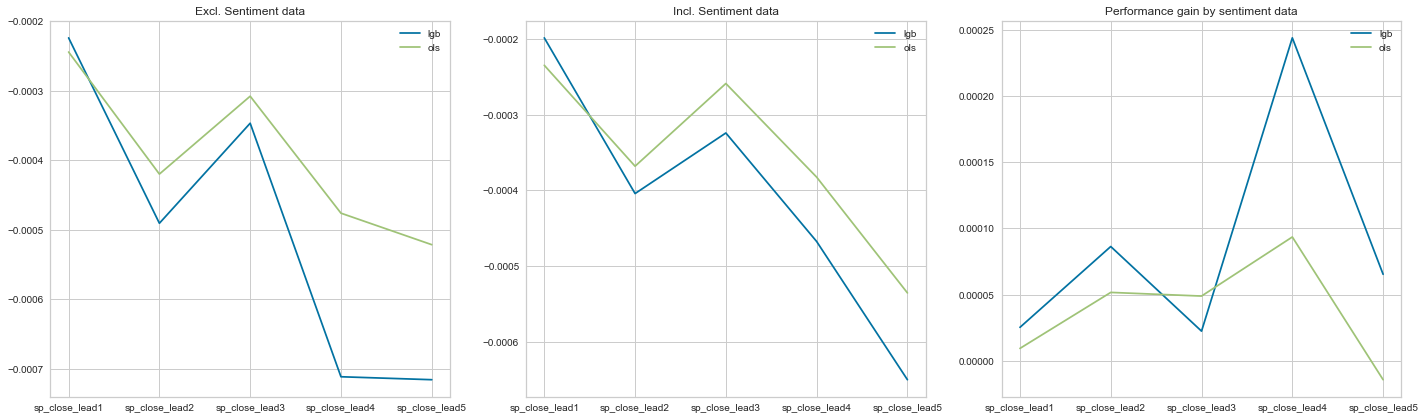

In [83]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

ax[1].plot(df_p.loc[True, 'lgb'])
ax[0].plot(df_p.loc[False, 'lgb'])

ax[1].plot(df_p.loc[True, 'ols'])
ax[0].plot(df_p.loc[False, 'ols'])

ax[2].plot(df_p.loc[True, 'lgb'] - df_p.loc[False, 'lgb'])
ax[2].plot(df_p.loc[True, 'ols'] - df_p.loc[False, 'ols'])

ax[0].legend(["lgb", "ols"])
ax[1].legend(["lgb", "ols"])
ax[2].legend(["lgb", "ols"])

ax[0].set_title("Excl. Sentiment data")
ax[1].set_title("Incl. Sentiment data")
ax[2].set_title("Performance gain by sentiment data")

# ax[0].set_ylim([-0.0008, 0])
# ax[1].set_ylim([-0.0008, 0])

plt.tight_layout()
plt.show()